Model Evaluation and Comparison:

- Use different evaluation metrics such as accuracy, precision, recall, and F1-score to assess the performance of the models.
- Compare the performance of the different models on both tasks, isCancerous and cell-type classification.
- Explore the use of the extra data provided in the Dataset_extra to improve the performance of the cell-type classification model and compare the results with the model trained on the main dataset.

Visualization:
- Visualize the classification results using confusion matrices, ROC curves, and precision-recall curves.
- Use activation maps or saliency maps to visualize the regions of the images that are important for the classification decision.

In [1]:
import sys

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
AUTOTUNE = tf.data.experimental.AUTOTUNE

sys.path.append('../../src')

In [2]:
dataset_main = pd.read_csv("../data/raw/data_labels_mainData.csv")
dataset_extra = pd.read_csv("../data/raw/data_labels_extraData.csv")

In [3]:
X_train, X_test = train_test_split(dataset_main, test_size = 0.2, random_state = 1)
X_train, X_val = train_test_split(X_train, test_size = 0.25, random_state = 1)

In [4]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_Val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (5937, 6)
Shape of X_Val: (1979, 6)
Shape of X_test: (1980, 6)


## Baseline model with Multi-layer Perceptron

In [7]:
X_train['isCancerous'] = X_train['isCancerous'].astype('str')
X_val['isCancerous'] = X_val['isCancerous'].astype('str')
X_test['isCancerous'] = X_test['isCancerous'].astype('str')

In [8]:
image_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = image_gen.flow_from_dataframe(
        dataframe=X_train,
        directory='../data/raw/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = image_gen.flow_from_dataframe(
        dataframe=X_val,
        directory='../data/raw/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = image_gen.flow_from_dataframe(
        dataframe=X_test,
        directory='../data/raw/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


In [9]:
input_dim = (27, 27, 3)
hidden_layer_dim = 256
output_classes = 2

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dim),
    tf.keras.layers.Dense(hidden_layer_dim, activation='sigmoid'),
    tf.keras.layers.Dense(output_classes)
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


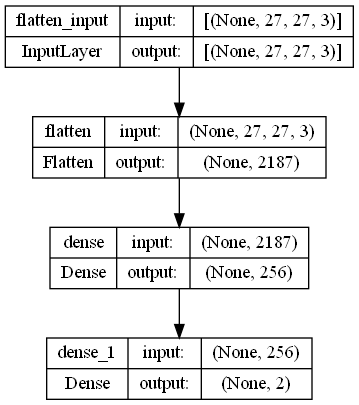

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
model.compile(optimizer='SGD', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [14]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

In [15]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

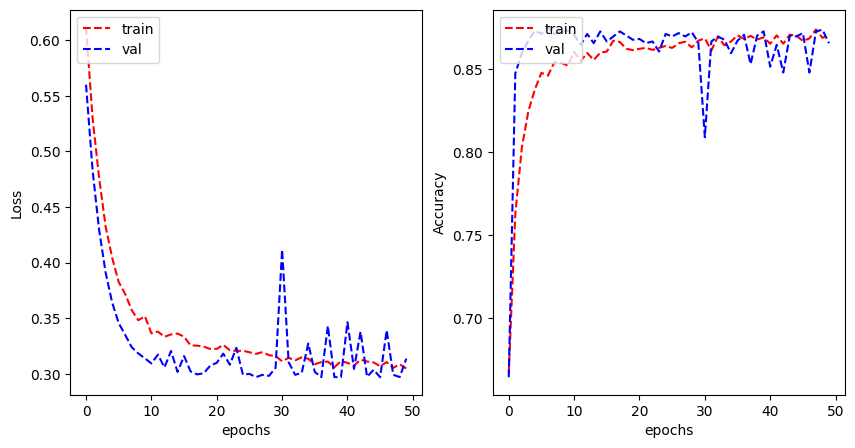

In [16]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [17]:
y_prediction = model.predict(validation_generator)
y_prediction = np.argmax (y_prediction, axis = 1)

74/74 [==============================] - 0s 4ms/step


In [19]:
y_test = X_val['isCancerous'].to_numpy(dtype="int64")

In [21]:
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)

[[0.59485224 0.58172043]
 [0.40514776 0.41827957]]


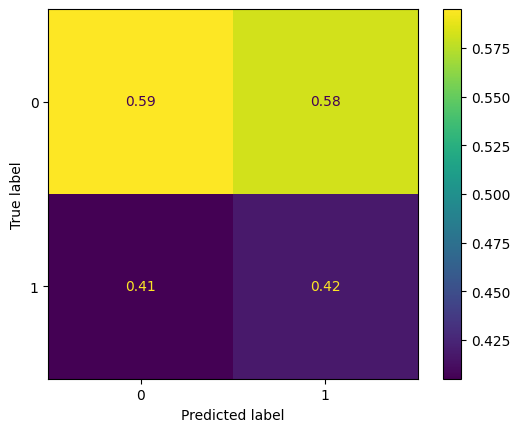

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=[0, 1])
disp.plot()
plt.show()

# Models

## CNN

To construct the model:

In [32]:
input_dim = (27, 27, 3)

cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_dim))
cnn_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
cnn_model.add(tf.keras.layers.Flatten(input_shape=input_dim))
cnn_model.add(tf.keras.layers.Dense(100, activation='sigmoid'))
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(2))
cnn_model.compile(optimizer='SGD', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               460900    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 202       
                                                      

In [30]:
history_cnn = cnn_model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

In [ ]:
# cnn_model.evaluate(test_generator)

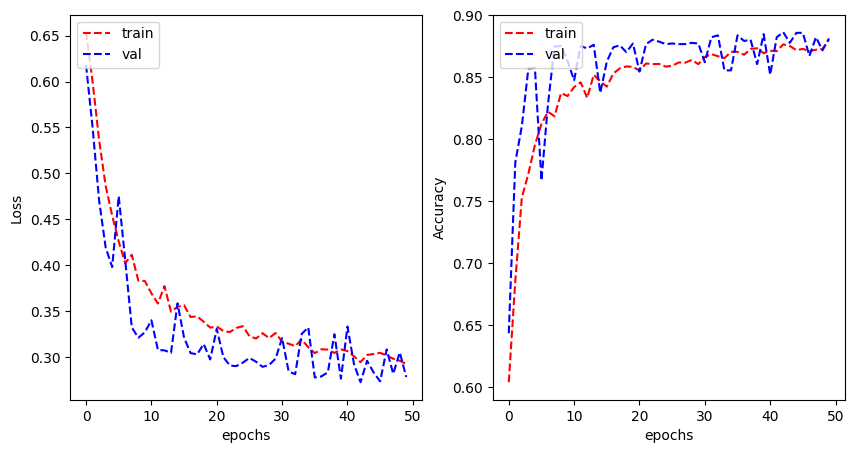

In [31]:
plot_learning_curve(history_cnn.history['loss'], history_cnn.history['val_loss'], 
                    history_cnn.history['categorical_accuracy'], history_cnn.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## SVM

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV



## Random Forest

# Hyperparameter Tuning

## Grid Search

## Random Search

## Plot Hyperparameters